In [14]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt
from sts_jax.causal_impact.causal_impact import causal_impact

### Generate the synthetic dataset

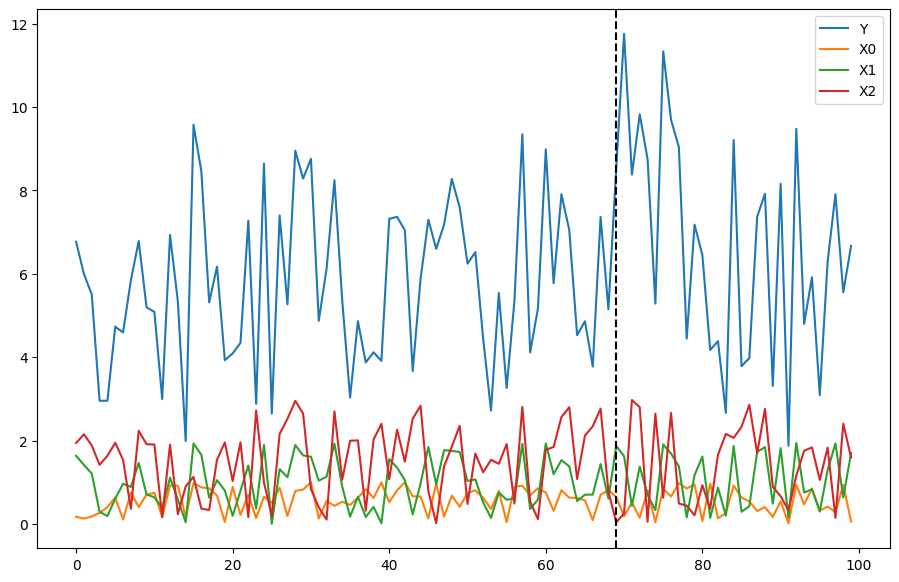

In [15]:
num_timesteps = 100
intervention_timepoint = 70

# Trend
def auto_regress(x, key):
    x_new = x + 1e-5*jr.normal(key)
    return x_new, x

keys = jr.split(jr.PRNGKey(0), 5)
trend_initial = jr.normal(keys[2])
_, trend =  lax.scan(auto_regress, trend_initial, jr.split(keys[1], num_timesteps))
trend = trend + 0.1*jr.normal(keys[2], shape=(num_timesteps,))

# Covariates
x0 = 1 * jr.uniform(keys[2], shape=(num_timesteps,))
x1 = 2 * jr.uniform(keys[3], shape=(num_timesteps,))
x2 = 3 * jr.uniform(keys[4], shape=(num_timesteps,))

# Time series without intervention effect
y = 2*x0 + 3*x1 + trend

# Observed time series
duration = 10
effect = jnp.linspace(5, 0, num=duration)
y = y.at[intervention_timepoint:intervention_timepoint+duration].set(
    y[intervention_timepoint:intervention_timepoint+duration]+effect)

# Plot the data
plt.figure(figsize=(11, 7))
plt.plot(y, color='C0', label='Y')
plt.plot(x0, color='C1', label='X0')
plt.plot(x1, color='C2', label='X1')
plt.plot(x2, color='C3', label='X2')
plt.axvline(x=intervention_timepoint-1, linestyle='dashed', color='black')
plt.legend()

plt.savefig("causal-impact-data.pdf")

### Infer the causal effect

In [16]:
obs_time_series = jnp.expand_dims(y, 1)
covariates = jnp.vstack((x0, x1, x2)).T

impact = causal_impact(obs_time_series, intervention_timepoint, 'Gaussian', covariates,
                       sts_model=None, confidence_level=0.95, key=jr.PRNGKey(0), num_samples=200)

Running window adaptation


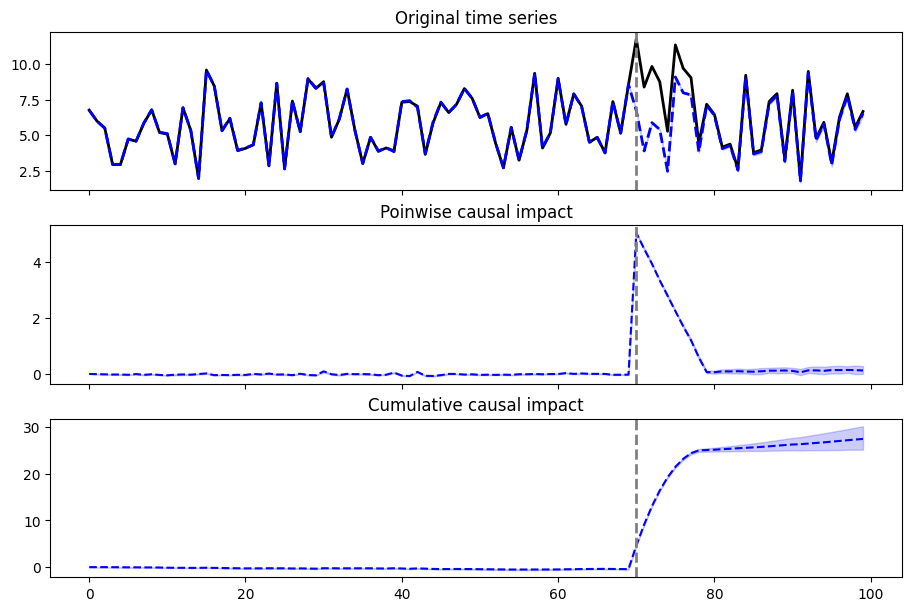

In [17]:
impact.plot()
plt.savefig("causal-impact-inferences.pdf")
plt.show()